LSTM STOCK PREDICTOR,

Works best with low volatility stocks

Import any STOCK CSV and chain line with arrow bellow

In [ ]:
#example Data Set https://ca.finance.yahoo.com/quote/CL?p=CL&.tsrc=fin-srch  set to 5 year length

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
#Data Manipulation. We want to index data using date and has the only feuture close
df = pd.read_csv("CL.csv")     # <-----------------------------------------------------------------------------------------------------------------------------------------
df = df[['Date','Close']]
def string_to_dateTime(string):
  split = string.split("-")
  year,month,day = int(split[0]),int(split[1]),int(split[2])
  return datetime.datetime(year=year, month=month,day=day)
df["Date"] = df["Date"].apply(string_to_dateTime)
df.index = df.pop("Date")


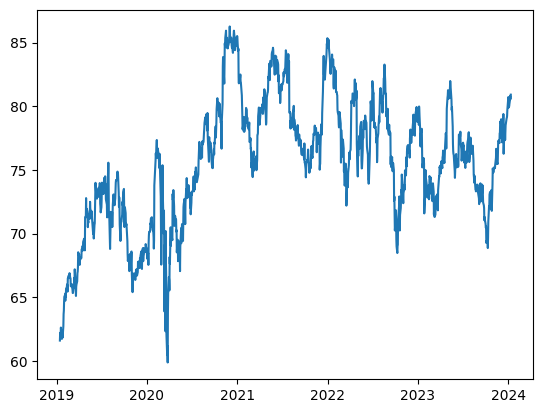

In [ ]:
plt.plot(df.index,df["Close"]) #REMOVE

In [ ]:
n = 3 #change n to change grouping (#number of inputs for each output)
def df_to_grouped_df(dataframe, n):  #change n to change grouping
  # aquire first usable and most recent date from data set
  first_date = str(df.index[n]).split()[0]
  last_date = str(df.index[-1]).split()[0]

  first_date = string_to_dateTime(first_date)
  last_date  = string_to_dateTime(last_date)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1) # last n+1 rows from target date
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return
    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]


    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Previous by {n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df
grouped_df = df_to_grouped_df(df,n=3)
grouped_df

,Target Date,Previous by 3,Previous by 2,Previous by 1,Target
0,2019-01-17,61.610001,62.220001,62.130001,62.000000
1,2019-01-18,62.220001,62.130001,62.000000,62.630001
2,2019-01-22,62.130001,62.000000,62.630001,61.740002
3,2019-01-23,62.000000,62.630001,61.740002,62.349998
4,2019-01-24,62.630001,61.740002,62.349998,62.200001
...,...,...,...,...,...
1251,2024-01-08,79.889999,80.339996,79.980003,80.400002
1252,2024-01-09,80.339996,79.980003,80.400002,80.820000
1253,2024-01-10,79.980003,80.400002,80.820000,80.550003
1254,2024-01-11,80.400002,80.820000,80.550003,80.559998


In [ ]:
train, validate, test = np.split(grouped_df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])
def df_to_date_X_y(df):
  df_as_np = df.to_numpy()
  dates = df_as_np[:,0]
  X = df_as_np[:,1:-1]
  X = X.reshape(len(dates),X.shape[1],1)
  y = df_as_np[:,-1]
  return dates, X.astype(np.float32), y.astype(np.float32)
dates,X,y = df_to_date_X_y(grouped_df)


In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]


In [ ]:
from typing import Sequence
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape = (3,1)),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(1,)
])
model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), metrics = ["mean_absolute_error"])
model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs = 100,verbose = 1)


Epoch 1/100
32/32 [==============================] - 3s 23ms/step - loss: 5619.9033 - mean_absolute_error: 74.7708 - val_loss: 5507.3701 - val_mean_absolute_error: 74.1682
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 5184.7510 - mean_absolute_error: 71.7785 - val_loss: 4483.8247 - val_mean_absolute_error: 66.9100
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 3092.1587 - mean_absolute_error: 54.7330 - val_loss: 1403.3346 - val_mean_absolute_error: 37.3720
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 488.6629 - mean_absolute_error: 18.9216 - val_loss: 8.3397 - val_mean_absolute_error: 2.2221
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 34.4839 - mean_absolute_error: 4.6951 - val_loss: 6.8200 - val_mean_absolute_error: 2.0882
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 29.2259 - mean_absolute_error: 4.4620 - val_loss: 6.7177 - val_mean_absolute_error:

4/4 [==============================] - 0s 4ms/step


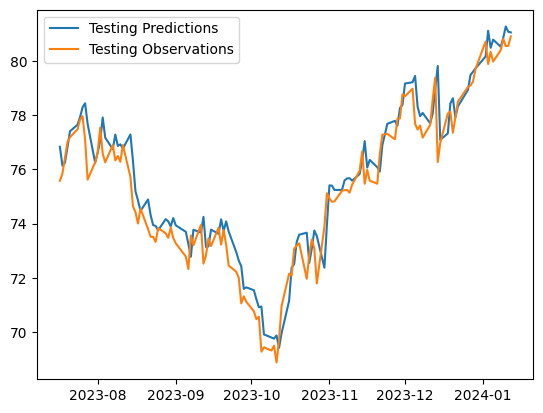

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

4/4 [==============================] - 0s 6ms/step


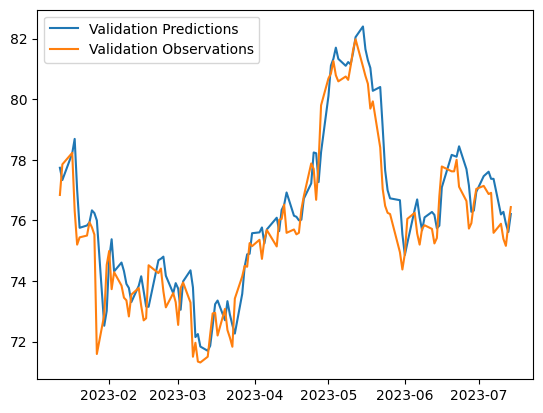

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

32/32 [==============================] - 0s 2ms/step


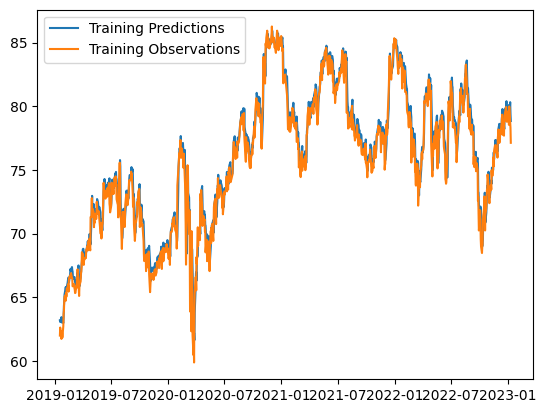

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])